In [24]:
# List of modules that are not installed in the course
!pip install OpenPermID
!pip install Levenshtein
!pip install geocoder

In [25]:
import pandas as pd
import numpy as np
import re

# Downloading all bonds ever owned in CSPP

In [26]:
import requests, datetime

In [27]:
# This function gets the csv from the url and places the new data in a dictionary with keys = ISIN,
# and value = [NCB, ISSUER, MATURITY DATE, COUPON RATE]
def downloadDataToDictionary(url,dictionary):
    r = requests.get(url) # create HTTP response object
    nameCompany = '' # make a string for the company name 
                     # (do this here so that is in scope of whole function)
    if r.status_code != 200: return # if website wasn't accessed in the right way, 
                                    # stop the function
    # this for loop loops through all the lines of the retrieved csv-file, except for the heading
    for line in r.text.split('\r\n')[1:]:
        if not re.search(r'[a-z]',line): continue # if the line doesn't contain letters, 
                                                  # go to the next line
        if re.search(r',+$',line): line = re.sub(r',+$',r'',line) # remove commas at end of line
        splitLine = line.split(',')
        if len(splitLine) < 5: continue # We expect at least 5 items as we want 5 columns 
                                        # and name could lead to additional columns
        if re.search(r'(?:\".*,.*\")',line): # searches commas between " as these are part of the name 
                                             # and shouldn't be split
            nameCompany = re.search(r'(?:\".*,.*\")',line).group(0) 
                                             # name of the company is between the ""
            nameCompany = re.sub(r"\"","",nameCompany) # remove the ""
        else:
            for str in splitLine:
                re.sub('\"','',str)
            nameCompany = splitLine[2]
        if (splitLine[1] not in dictionary): # only add new ISINs to the dictionary
            dictionary[splitLine[1]] = [splitLine[0], nameCompany, splitLine[-2], splitLine[-1]]

In [28]:
dateToDownload = datetime.date(2017, 6, 23)
change_url_date = datetime.date(2020, 3, 27)
end_date = datetime.date.today()
delta = datetime.timedelta(days=7)
dictionaryBondsECB = {}

while dateToDownload <= change_url_date:
    date = dateToDownload.strftime("%Y%m%d")
    url = "https://www.ecb.europa.eu/mopo/pdf/CSPPholdings_"+date+".csv"
    downloadDataToDictionary(url,dictionaryBondsECB)
    dateToDownload += delta
dateToDownload+delta
while dateToDownload <= end_date:
    date = dateToDownload.strftime("%Y%m%d")
    url = "https://www.ecb.europa.eu/mopo/pdf/CSPP_PEPP_corporate_bond_holdings_"+date+".csv"
    downloadDataToDictionary(url,dictionaryBondsECB)
    dateToDownload += delta

In [29]:
matrixData = [] # 2D array with row per ISIN and columns for different data
for ISIN, dataInDictionary in dictionaryBondsECB.items():
    item = [ISIN] + dataInDictionary
    matrixData.append(item)
holdingsECB = pd.DataFrame(matrixData, columns=["ISIN","NCB","ISSUER","MATURITY DATE","COUPON RATE"])

# ECB green bonds that are listed on Euronext stock exchange 

In [ ]:
#reading data of green bonds listed on Euronext 
euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)
euronext_greenbonds

In [ ]:
#Getting the ISIN of the Euronext green bonds 
euronext_greenbond_isin = euronext_greenbonds["ISIN"]
euronext_greenbond_isin

In [ ]:
#Comparing the ISINs of the ECB and Euronext green bonds and returning matches 
ecbgreenbonds = holdingsECB[(holdingsECB["ISIN"].isin(euronext_greenbond_isin))]
ecbgreenbonds

# Which bonds are green?

In [ ]:
# reading data of which bonds are held by ECB at 2nd of april 2021
holdings20210402 = pd.read_csv("data/CSPP_PEPP_corporate_bond_holdings_20210402.csv", header=0, encoding='latin-1')
holdings20210402

In [ ]:
# reading data of all green bonds in the world (ICMA - 06 april 2021)
greenBonds = pd.read_csv("data/ICMA-Sustainable-Bonds-Database-060421.csv", delimiter=";", encoding="latin-1")
greenBonds

In [ ]:
# generate lists of all companies that have green bonds owned by ECB and all companies that have non-green bonds owned by ECB
companiesECBSet = set(holdings20210402["ISSUER"].tolist()) # set of companies with bonds owned by ECB
greenBondsCompaniesSet = set(greenBonds["Green Bond issuer"].tolist()) # set of companies with green bonds
greenCompanies = [] # this list will hold all companies with green bonds owned by ECB
for company in companiesECBSet:
    for greenBondCompany in greenBondsCompaniesSet:
        # Here, regex are used because names don't exactly match
        if (re.search(".*"+greenBondCompany+".*", company) or re.search(".*"+company+".*",greenBondCompany)):
            greenCompanies.append(company)

# Using OpenFIGI to convert bond ISIN to ticker
FIGIs are unique identifiers of financial instruments issued by Bloomberg. OpenFIGI is an API that maps third-party identifiers to FIGI, but it also returns other information such as company name and ticker.

In [ ]:
# Import Packages
import json
import urllib.request
import urllib.parse

In [ ]:
# Load Functions
def map_jobs(jobs):
    handler = urllib.request.HTTPHandler()
    opener = urllib.request.build_opener(handler)
    openfigi_url = 'https://api.openfigi.com/v3/mapping'
    request = urllib.request.Request(openfigi_url, data=bytes(json.dumps(jobs), encoding='utf-8'))
    request.add_header('Content-Type','application/json')
    if openfigi_apikey:
        request.add_header('X-OPENFIGI-APIKEY', openfigi_apikey)
    request.get_method = lambda: 'POST'
    connection = opener.open(request)
    if connection.code != 200:
        raise Exception('Bad response code {}'.format(str(response.status_code)))
    return json.loads(connection.read().decode('utf-8'))

def job_results_handler(jobs, job_results):
    df = pd.DataFrame({})
    for job, result in zip(jobs, job_results):
        job_df = pd.DataFrame({'ISIN': [job['idValue']]})
        results_df = pd.read_json(json.dumps(result.get('data', [])))
        df = pd.concat([df, pd.concat([job_df, results_df], axis = 1)])
    return df

In [ ]:
# Convert raw data to appropriate input format
ISIN_FIGI = pd.concat([pd.Series(np.tile('ID_ISIN', 1642)), holdings20210402.ISIN], axis = 1)
ISIN_FIGI = ISIN_FIGI.rename(columns = {0: 'idType', 'ISIN': 'idValue'})

# Map to FIGI
openfigi_apikey = 'c89ac66d-e0d2-416f-9c5e-0ed7ec59c770' # This is my personal key (Fred)
jobs_per_access = 100
no_of_access = len(ISIN_FIGI)//jobs_per_access + 1

figi = pd.DataFrame({})
for i in range(no_of_access):
    lower_bound = jobs_per_access * i
    upper_bound = jobs_per_access * (i + 1) if i < no_of_access - 1 else max(ISIN_FIGI.index) + 1
    job = ISIN_FIGI.iloc[lower_bound:upper_bound].to_dict(orient = 'records')
    job_results = map_jobs(job)
    figi = figi.append(job_results_handler(job, job_results))
    
# Extracting the pure ticker
figi.ticker = figi.ticker.apply(lambda x: x.split()[0])
figi.head()

# Percentage of companies supported by ECB with green ESG scores

Next 4 blocks calculate the score of a given ticker with the function 'web_scraper(ticker)' as shown by the example for Microsoft Corporation (MSFT).
TODO: Find the ticker belonging to each company and iterate over them to see if the ESG score or the Environment Score indicate that the given company is green.

In [ ]:
# Source used: https://curt-beck1254.medium.com/scrapping-financial-esg-data-with-python-99d171a12c51
from bs4 import BeautifulSoup
# import pandas as pd
import requests

In [ ]:
def web_scraper(ticker):
    elements = []
    web_data = requests.get('https://finance.yahoo.com/quote/'+ticker+'/sustainability?p='+ticker).text
    soup = BeautifulSoup(web_data, 'html.parser')
    esg_score = soup.find('div', {'class':'Fz(36px) Fw(600) D(ib) Mend(5px)'})
    datapoint = esg_score.text if esg_score != None else np.NaN
    controversy_score = soup.find('div', {'class': 'D(ib) Fz(23px) smartphone_Fz(22px) Fw(600)'})
    controversy_datapoint = controversy_score.text if controversy_score != None else np.NaN
    scores = soup.find_all('div', {'class': 'D(ib) Fz(23px) smartphone_Fz(22px) Fw(600)'})
    if len(scores) == 0:
        elements = [np.NaN, np.NaN, np.NaN]
    else:
        for score in scores:
            elements.append(score.text)
        
    df = pd.DataFrame({'Total ESG Score': datapoint,
                      'Environment Score': elements[0],
                       'Social Score': elements[1],
                      'Governance Score': elements[2],
                      'Controversy Score': controversy_datapoint},
                     index=[ticker])
    df = df.astype('float')
    df['Controversy Assessment'] = df.apply(lambda x: level(x['Controversy Score']), axis=1)
    return df

In [ ]:
def level(x):
    if x == 0.0:
        return 'No Controversy'
    if x == 1.0:
        return 'Little Controverssy'
    if x == 2.0:
        return 'Moderate Controversy'
    if x == 3.0:
        return 'Relatively High Controversy'
    else:
        return 'Severe Controversy'

In [ ]:
web_scraper('MSFT')

In [ ]:
ESG_Summary = pd.DataFrame({})
for i in set(figi.ticker.iloc[0:50].tolist()):
    ESG_Summary.append(web_scraper(i))
ESG_Summary

# Find Sectors and Locations of Companies

In [115]:
# Requirements
from OpenPermID import OpenPermID
import Levenshtein
import geocoder

In [116]:
# Gain access to the permid database
opid = OpenPermID()
opid.set_access_token("r95vEAhvmucG8iNGtsP17hjbgUGMhz4j")

In [117]:
companies = holdings20210402.ISSUER.astype('string').unique()
permid_mappings = pd.DataFrame({})
unmapped_companies = []

for company in companies:
    
    # In case of connection error, allow it to try at most 5 times
    err, count = 0, 0
    while (err != None and count < 5):
        output, err = opid.search(company)
    if err != None:
        unmapped_companies.append(company)
        continue
    
    
    df = output['organizations']
    if len(df) == 0:
        permid = np.NaN
        name = np.NaN
    elif len(df) == 1:
        permid = df.iloc[0,0].split('/')[-1]
        name = df.iloc[0,1]
    else:
        # If multiple records are return, choose the record which the company name is the most similar to the keyword
        similarityScores = df.organizationName.apply(lambda x: Levenshtein.ratio(company, x))
        max_index = similarityScores.idxmax()
        permid = df.iloc[max_index, 0].split('/')[-1]
        name = df.iloc[max_index, 1]
    permid_mappings = permid_mappings.append(pd.DataFrame({'keyword':[company], 'companyName': [name], 'PermID':[permid]}))
    
permid_mappings

,keyword,companyName,PermID
0,Elia Transmission Belgium,Elia Transmission Belgium NV,1-5071549731
0,Enodia SCRL,Enodia SCRL,1-4297881749
0,Groupe Bruxelles Lambert SA,Groupe Bruxelles Lambert SA,1-5066557287
0,Fluvius System Operator CVBA,Fluvius System Operator CVBA,1-4297633980
0,BEFIMMO SA,Befimmo SA,1-4295859373
...,...,...,...
0,Esselunga S.p.A.,Esselunga SpA,1-4297965300
0,ERG S.p.A,ERG SpA,1-4295875564
0,RAI - RADIOTELEVISIONE ITALIANA SPA,RAI Radiotelevisione Italiana SpA,1-4296949624
0,Infrastrutture Wireless Italiane S.p.A,Infrastrutture Wireless Italiane SpA,1-5045517782


In [118]:
permids = permid_mappings.PermID.dropna().astype('string')
sector_lookups = pd.DataFrame({})
unsuccessful_lookups = []

for permid in permids:
    
    # In case of connection error, allow it to try at most 5 times
    err, count = 0, 0
    while (err != None and count < 5):
        output, err = opid.lookup(permid)
    if err != None:
        unsuccessful_lookups.append(permid)
        continue

    if "hasPrimaryBusinessSector" in output.columns:
        sector_info = output.loc[:, 'hasPrimaryBusinessSector': 'hasPrimaryIndustryGroup']
        sector_info = sector_info.applymap(lambda x: x.split('/')[-1])
    if "isIncorporatedIn" in output.columns:
        loc_info = output.loc[:, 'isIncorporatedIn': 'isDomiciledIn']
        loc_info = loc_info.applymap(lambda x: x.split('/')[-2])
        
    row = pd.DataFrame({'PermID': [permid]})
    row = pd.concat([row, sector_info], axis = 1) if type(sector_info) == pd.DataFrame else row
    row = pd.concat([row, loc_info], axis = 1) if type(loc_info) == pd.DataFrame else row
    sector_lookups = sector_lookups.append(row)
    
    sector_info, loc_info = None, None

sector_lookups

,PermID,hasPrimaryBusinessSector,hasPrimaryEconomicSector,hasPrimaryIndustryGroup,isIncorporatedIn,isDomiciledIn
0,1-5071549731,1-4294952820,1-4294952821,1-4294952819,2802361,2802361
0,1-4297881749,1-4294952739,1-4294952740,1-4294952738,2802361,2802361
0,1-5066557287,1-4294952773,1-4294952774,1-4294952976,2802361,2802361
0,1-4297633980,1-4294952820,1-4294952821,1-4294952813,2802361,2802361
0,1-4295859373,1-4294952860,1-1004365438,1-4294952857,2802361,2802361
...,...,...,...,...,...,...
0,1-4297965300,1-4294952880,1-4294952895,1-4294952879,3175395,3175395
0,1-4295875564,1-4294952820,1-4294952821,1-4294952819,3175395,3175395
0,1-4296949624,1-4294952915,1-4294952746,1-4294952742,3175395,3175395
0,1-5045517782,1-4294952825,1-4294952723,1-4294952824,3175395,3175395


In [119]:
sector_lookups_converted = sector_lookups.copy()
sector_types = sector_lookups.columns[1:4]
for sector_type in sector_types:
    sector_dict = {}
    sectors = sector_lookups.loc[:, sector_type].dropna().astype('string').unique()
    for sector in sectors:
        output, err = opid.lookup(sector)
        sector_dict[sector] = output.iloc[0, -1]
    sector_lookups_converted[sector_type] = sector_lookups[sector_type].fillna('missing').astype('string').apply(lambda x: np.NaN if x == 'missing' else sector_dict[x])

loc_types = sector_lookups.columns[4:]
for loc_type in loc_types:
    loc_dict = {}
    locs = sector_lookups.loc[:, loc_type].dropna().astype('string').unique()
    for loc in locs:
        g = geocoder.geonames(loc, method='details', key='brian1998716')
        loc_dict[loc] = g.address
    sector_lookups_converted[loc_type] = sector_lookups[loc_type].fillna('missing').astype('string').apply(lambda x: np.NaN if x == 'missing' else loc_dict[x])

sector_lookups_converted

,PermID,hasPrimaryBusinessSector,hasPrimaryEconomicSector,hasPrimaryIndustryGroup,isIncorporatedIn,isDomiciledIn
0,1-5071549731,Utilities,Utilities,Electric Utilities & IPPs,Belgium,Belgium
0,1-4297881749,Banking & Investment Services,Financials,Investment Banking & Investment Services,Belgium,Belgium
0,1-5066557287,Mineral Resources,Basic Materials,Construction Materials,Belgium,Belgium
0,1-4297633980,Utilities,Utilities,Multiline Utilities,Belgium,Belgium
0,1-4295859373,Real Estate,Real Estate,Residential & Commercial REITs,Belgium,Belgium
...,...,...,...,...,...,...
0,1-4297965300,Food & Drug Retailing,Consumer Non-Cyclicals,Food & Drug Retailing,Italy,Italy
0,1-4295875564,Utilities,Utilities,Electric Utilities & IPPs,Italy,Italy
0,1-4296949624,Cyclical Consumer Services,Consumer Cyclicals,Media & Publishing,Italy,Italy
0,1-5045517782,Telecommunications Services,Technology,Telecommunications Services,Italy,Italy


In [120]:
sector_mappings = pd.merge(permid_mappings, sector_lookups_converted, how = 'left', on = 'PermID')
sector_mappings

,keyword,companyName,PermID,hasPrimaryBusinessSector,hasPrimaryEconomicSector,hasPrimaryIndustryGroup,isIncorporatedIn,isDomiciledIn
0,Elia Transmission Belgium,Elia Transmission Belgium NV,1-5071549731,Utilities,Utilities,Electric Utilities & IPPs,Belgium,Belgium
1,Enodia SCRL,Enodia SCRL,1-4297881749,Banking & Investment Services,Financials,Investment Banking & Investment Services,Belgium,Belgium
2,Groupe Bruxelles Lambert SA,Groupe Bruxelles Lambert SA,1-5066557287,Mineral Resources,Basic Materials,Construction Materials,Belgium,Belgium
3,Fluvius System Operator CVBA,Fluvius System Operator CVBA,1-4297633980,Utilities,Utilities,Multiline Utilities,Belgium,Belgium
4,BEFIMMO SA,Befimmo SA,1-4295859373,Real Estate,Real Estate,Residential & Commercial REITs,Belgium,Belgium
...,...,...,...,...,...,...,...,...
350,Esselunga S.p.A.,Esselunga SpA,1-4297965300,Food & Drug Retailing,Consumer Non-Cyclicals,Food & Drug Retailing,Italy,Italy
351,ERG S.p.A,ERG SpA,1-4295875564,Utilities,Utilities,Electric Utilities & IPPs,Italy,Italy
352,RAI - RADIOTELEVISIONE ITALIANA SPA,RAI Radiotelevisione Italiana SpA,1-4296949624,Cyclical Consumer Services,Consumer Cyclicals,Media & Publishing,Italy,Italy
353,Infrastrutture Wireless Italiane S.p.A,Infrastrutture Wireless Italiane SpA,1-5045517782,Telecommunications Services,Technology,Telecommunications Services,Italy,Italy


In [121]:
sector_mappings.count()

keyword                     355
companyName                 325
PermID                      325
hasPrimaryBusinessSector    303
hasPrimaryEconomicSector    303
hasPrimaryIndustryGroup     303
isIncorporatedIn            319
isDomiciledIn               319
dtype: int64

# Get all industries in which ECB invested

1) Import all the data into one big data frame (done)
2) Search for all the ISINs
3) Find "green bond", "ESG bond" and most importantly "sector"
4) Analyse sectoer ?! --> TODO

In [62]:
import pandas as pd
import os

In [63]:
folder_files = os.listdir("data/Sector_data/")
sector_data = pd.DataFrame({})
for file in folder_files:
    if (file != '.ipynb_checkpoints'): # TODO: find cleaner way
        sector_data_extra = pd.ExcelFile("data/Sector_data/"+file)
        sector_data = sector_data.append(sector_data_extra.parse())

In [105]:
merged_sector_data = holdingsECB.merge(sector_data, "left", "ISIN")
merged_sector_data = merged_sector_data.dropna(subset=['Issuer'])
#merged_sector_data.to_excel('data/Sector_data/test_output.xlsx') # Export the resulting data to an excel file

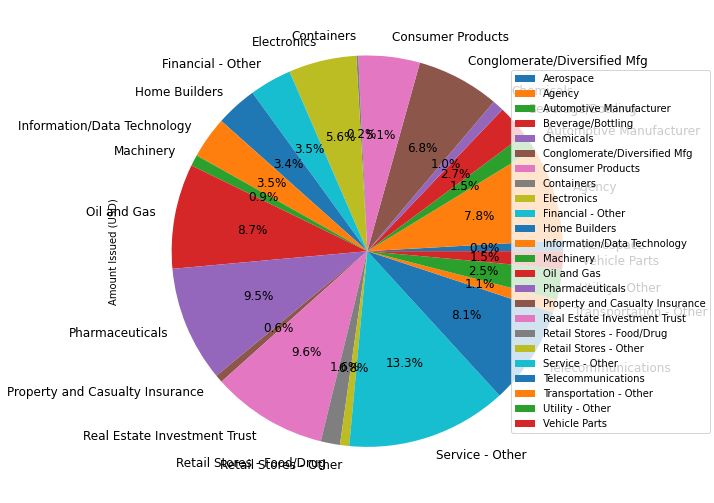

In [179]:
# Make a pie chart that shows the division of "Amount Issued" over all the different sectors present in the merged_sector_data dateframe
merged_sector_data["Amount Issued (USD)"] = pd.to_numeric(merged_sector_data["Amount Issued (USD)"], errors='raise', downcast=None)

import matplotlib.pyplot as plt # TODO: add to requirements
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111)

merged_sector_data.groupby(['Sector']).sum().plot(kind='pie', y='Amount Issued (USD)', ax=ax, autopct='%1.1f%%', fontsize=12, legend=False)
fig.legend(loc="right")